# Assignment - Video Summarisation 

## Mohammed Aadil - IIT2018179

------

## Including the required Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

------

## Utility Functions

In [2]:
def showimg(img, j):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    plt.subplot(3,3,j+1)
    plt.imshow(img)
    plt.title("frame" + str(count+1))
    
def similarity(img1, img2):
    # Initiate ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Initiate a BF matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Makes the matches
    matches = bf.match(des1, des2)

    # Find similar regions
    similar_regions = [i for i in matches if i.distance < 50]
    if len(matches) == 0:
        return 0
    
    return len(similar_regions)/len(matches)

def matching(img1, img2):
    orb = cv2.ORB_create()

    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(des1, des2, None)
    matches = sorted(matches, key=lambda x:x.distance)

    p1 = np.zeros((len(matches), 2), dtype=np.float32)
    p2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i,match in enumerate(matches):
        p1[i, :] = kp1[match.queryIdx].pt
        p2[i, :] = kp2[match.trainIdx].pt
    h, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    H, W, C = img2.shape
    R = cv2.warpPerspective(img1, h, (W, H))

    similarities = cv2.drawMatches(img1, kp1, img2, kp2, matches, None)
    
    return similarities

------

## Analysing Different Approaches

#### 1) [Subtracting Frames](#Difference-between-the-frames)
#### 2) [Extracting Key Frames](#Keypoints-Between-the-Frames-Using-ORB)

In [3]:
vidcap = cv2.VideoCapture('CCTV.mp4')
_, img1 = vidcap.read()
_, img2 = vidcap.read()

c = 3
ret = True
while ret and c<50:
    ret, img3 = vidcap.read()
    c += 1

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

### Difference between the frames

This method can be used but this is very time taking and impractical for larger video sizes.

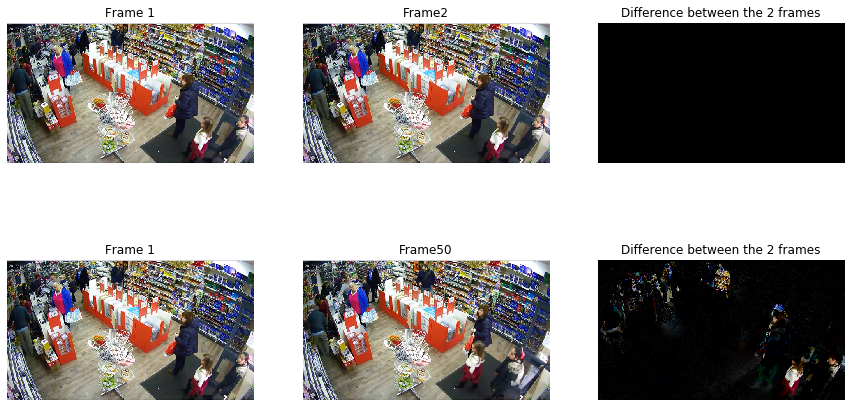

In [4]:
imlist = [img2, img3]
imnum = [2, 50]
plt.figure(figsize=(15,8))

for i in range(2):
    plt.subplot(2,3,1+3*i)
    plt.imshow(img1)
    plt.axis("off")
    plt.title("Frame 1")

    plt.subplot(2,3,2+3*i)
    plt.imshow(imlist[i])
    plt.axis("off")
    plt.title("Frame" + str(imnum[i]))

    plt.subplot(2,3,3+3*i)
    diff = cv2.subtract(img1, imlist[i])
    plt.imshow(diff)
    plt.axis("off")
    plt.title("Difference between the 2 frames")
    
plt.show()

### Keypoints Between the Frames Using ORB

If we take the case of **frame 1** and **frame 2** we see that there are a lot of horizintal lines **(correct matches)**


In the case of **frame 1** and **frame 100** we see that there are many slanting lines **(incorrect matches)**

Similarity frame 1 and frame 2 =  1.0 %
Similarity frame 1 and frame 50 =  0.8401162790697675 %


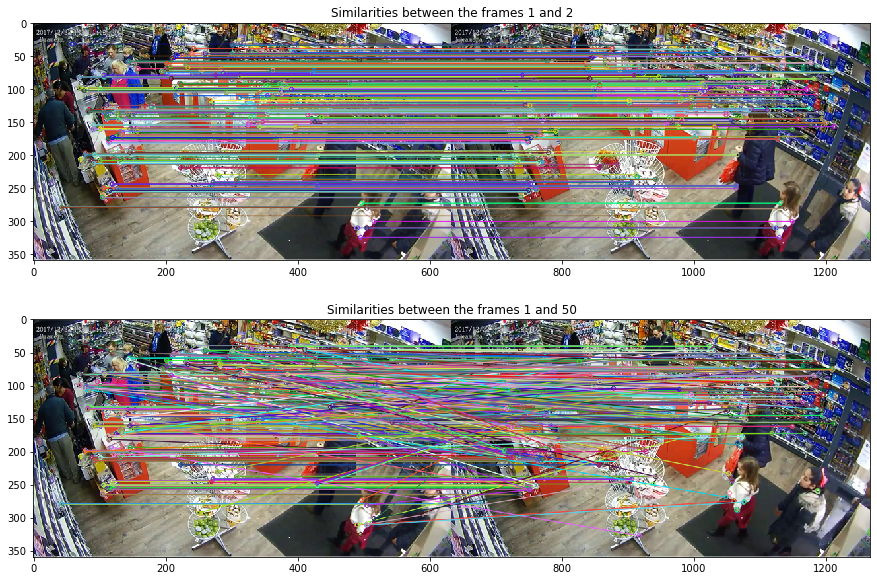

In [5]:
plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
similarities = matching(img1, img2)
plt.imshow(similarities)
plt.title('Similarities between the frames 1 and 2')
print("Similarity frame 1 and frame 2 = ", similarity(img1, img2), "%")

plt.subplot(2, 1, 2)
similarities = matching(img1, img3)
plt.imshow(similarities)
plt.title('Similarities between the frames 1 and 50')
print("Similarity frame 1 and frame 50 = ", similarity(img1, img3), "%")

plt.show()

------
## Implementation of ORB Method on the Video

### Reading the video frame by frame

In [6]:
vidcap = cv2.VideoCapture('CCTV.mp4')
success, image = vidcap.read()

frames = []
while(success):
    success, image = vidcap.read()
    frames.append(image)

### Extracting the Key Frames

In [7]:
threshold = .85
num_frames = len(frames)
keyframes = [frames[0]]

i = 0
for j in tqdm(range(num_frames-1)):
    sim = similarity(frames[i], frames[j])
    if(sim < threshold):
        keyframes.append(frames[j])
        i = j

100%|██████████| 1282/1282 [00:29<00:00, 43.22it/s]


### Number of Key Frames

In [8]:
len(keyframes)

143

-----

## Exporting the images into a video

In [9]:
video = cv2.VideoWriter("Summary.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 24, (keyframes[0].shape[::-1][1:]))
for i in range(len(keyframes)):
    video.write(keyframes[i])
video.release()

------

## References

**1) Function Descriptions** : [Feature Detection and Description](https://docs.opencv.org/master/db/d27/tutorial_py_table_of_contents_feature2d.html)

**2) OpenCV ORB** : [ORB Documentation](https://docs.opencv.org/master/d1/d89/tutorial_py_orb.html)

**3) OpenCV Matcher** : [Feature Matching](https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html)

**4) Video Link** : [Youtuber - yyyzzzz](https://www.youtube.com/watch?v=5c1cNMnvTsw)